In [ ]:
%tensorflow_ver.sion 1.x

UsageError: Line magic function `%tensorflow_ver.sion` not found.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import seaborn as sns
import sys

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "BTC_USD_1D.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [ ]:
df = pd.read_csv(csv_path)
df = df.drop(columns=['Unnamed: 0', 'symbol', 'time'], axis=1)

In [ ]:
df.head()

,open,close,high,low,volume
0,92.500000,93.033000,93.74999,91.00000,3083.079791
1,93.250000,103.999000,105.90000,92.49999,5224.401313
2,104.000000,118.229354,118.38670,99.00000,8376.527478
3,117.958261,134.700000,146.88000,101.51088,12996.245072
4,134.716560,132.899000,143.00000,119.00000,6981.668305


In [ ]:
df.tail()

,open,close,high,low,volume
2548,6249.5,5892.700000,6280.0,5892.6,11218.706583
2549,5892.6,6407.600000,6636.0,5880.9,12378.558906
2550,6407.6,6427.682786,6536.0,6349.7,5753.093132
2551,6429.0,6675.000000,6726.5,6180.0,11234.474996
2552,6679.5,6841.300000,7283.5,6580.0,15720.502345


In [ ]:
df.shape

(2553, 5)

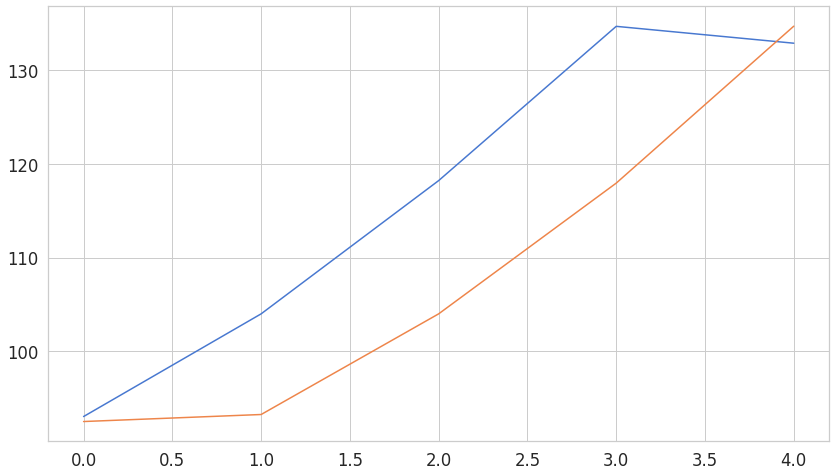

In [ ]:
plt.plot(df['close'].head())
plt.plot(df['open'].head())

# Normalization

In [ ]:
close_price = df['close']
open_price = df['open']
high_price = df['high']
low_price = df['low']
vol_price = df['volume']

In [ ]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)
open_price = df.open.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)
scaled_open = scaler.fit_transform(open_price)

In [ ]:
scaled_close.shape, scaled_open.shape

((2553, 1), (2553, 1))

In [ ]:
np.isnan(scaled_close).any()
np.isnan(scaled_open).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_open = scaled_open[~np.isnan(scaled_open)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)
scaled_open = scaled_open.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any(), np.isnan(scaled_open).any()

(False, False)

# Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train_close, y_train_close, X_test_close, y_test_close = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)
X_train_open, y_train_open, X_test_open, y_test_open = preprocess(scaled_open, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train_open.shape, X_train_close.shape

((2330, 99, 1), (2330, 99, 1))

In [ ]:
X_test_close.shape, X_test_open.shape

((123, 99, 1), (123, 99, 1))

# Model

In [ ]:
def train_model(X_train, X_test, y_train, y_test):
    DROPOUT = 0.2
    WINDOW_SIZE = SEQ_LEN - 1

    model = keras.Sequential()

    model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                            input_shape=(WINDOW_SIZE, X_train.shape[-1])))
    model.add(Dropout(rate=DROPOUT))

    model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))

    model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

    model.add(Dense(units=1))

    model.add(Activation('linear'))
    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
    )
    BATCH_SIZE = 64

    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=BATCH_SIZE,
        shuffle=False,
        validation_split=0.1
    )
    model.evaluate(X_test, y_test)
    results = model.predict(X_test)
    y_hat = model.predict(X_test)

    y_test_inverse = scaler.inverse_transform(y_test)
    y_hat_inverse = scaler.inverse_transform(y_hat)

    plt.plot(y_test_inverse, label="Actual Price", color='green')
    plt.plot(y_hat_inverse, label="Predicted Price", color='red')

    plt.title('Bitcoin price prediction')
    plt.xlabel('Time [days]')
    plt.ylabel('Price')
    plt.legend(loc='best')

    plt.show()
    return model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 2097 samples, validate on 233 samples
Epoch 1/50
2097/2097 [==============================] - 36s 17ms/sample - loss: 0.0162 - val_loss: 0.1012
Epoch 2/50
2097/2097 [==============================] - 2s 796us/sample - loss: 0.0162 - val_loss: 0.0220
Epoch 3/50
2097/2097 [==============================] - 2s 746us/sample - loss: 0.0228 - val_loss: 0.0041
Epoch 4/50
2097/2097 [==============================] - 2s 745us/sample - loss: 0.0181 - val_loss: 0.0199
Epoch 5/50
2097/2097 [==============================] - 2s 752us/sample - loss: 0.0057 - val_l

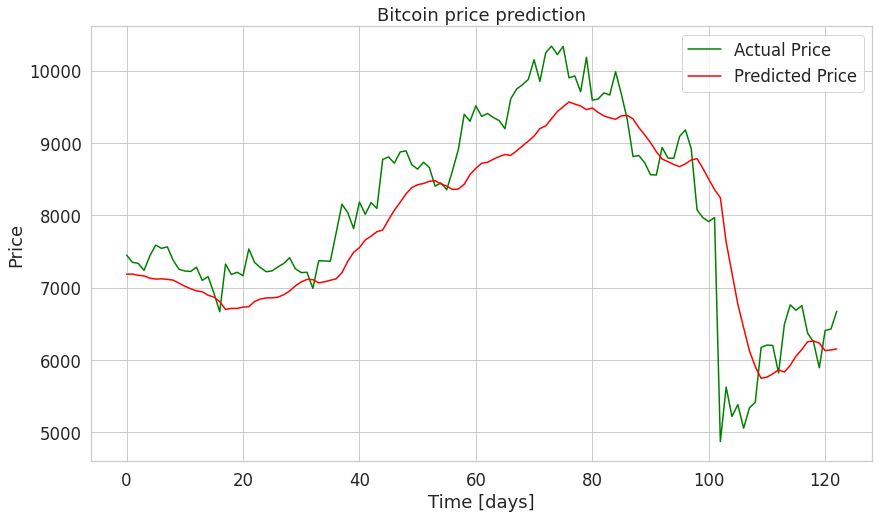

In [ ]:
close_model = train_model(X_train_close, X_test_close, y_train_close, y_test_close)

Train on 2097 samples, validate on 233 samples
Epoch 1/50
2097/2097 [==============================] - 3s 1ms/sample - loss: 0.0158 - val_loss: 0.1060
Epoch 2/50
2097/2097 [==============================] - 2s 740us/sample - loss: 0.0195 - val_loss: 0.0173
Epoch 3/50
2097/2097 [==============================] - 2s 741us/sample - loss: 0.0223 - val_loss: 0.0078
Epoch 4/50
2097/2097 [==============================] - 2s 746us/sample - loss: 0.0184 - val_loss: 0.0081
Epoch 5/50
2097/2097 [==============================] - 2s 743us/sample - loss: 0.0090 - val_loss: 0.0654
Epoch 6/50
2097/2097 [==============================] - 2s 749us/sample - loss: 0.0177 - val_loss: 0.0756
Epoch 7/50
2097/2097 [==============================] - 2s 751us/sample - loss: 0.0193 - val_loss: 0.0093
Epoch 8/50
2097/2097 [==============================] - 2s 752us/sample - loss: 0.0321 - val_loss: 0.0175
Epoch 9/50
2097/2097 [==============================] - 2s 753us/sample - loss: 0.0211 - val_loss: 0.0045
E

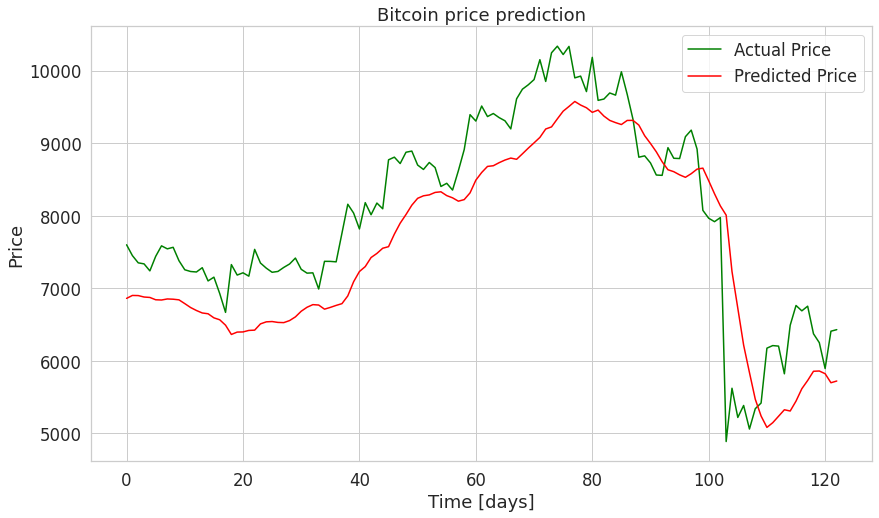

In [ ]:
open_model = train_model(X_train_open, X_test_open, y_train_open, y_test_open)

In [ ]:
price_mean = df['open'] + df['close'] / 2

In [ ]:
price_mean = np.array(price_mean.tolist())
price_mean_1 = price_mean[:-1]
price_mean_2 = price_mean[1:]
price_diff = price_mean_2 - price_mean_1

In [ ]:
np.min(price_mean), np.max(price_mean)

(100.06, 28689.0)

In [ ]:
min(df['open']), min(df['close'])

(66.12, 66.12)

Text(0.5, 1.0, 'bitcoin price fluctuation distribution')

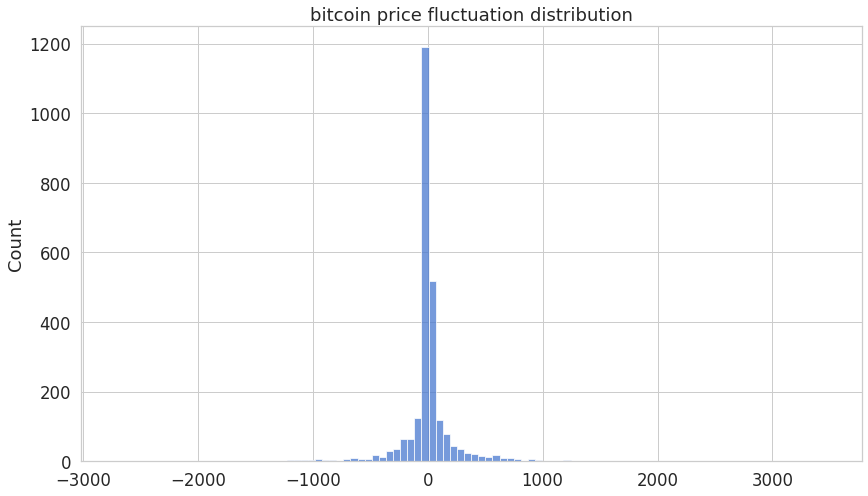

In [ ]:
sns.histplot(price_diff, bins=100,).set_title('bitcoin price fluctuation distribution')

Text(0.5, 1.0, 'bitcoin price distribution')

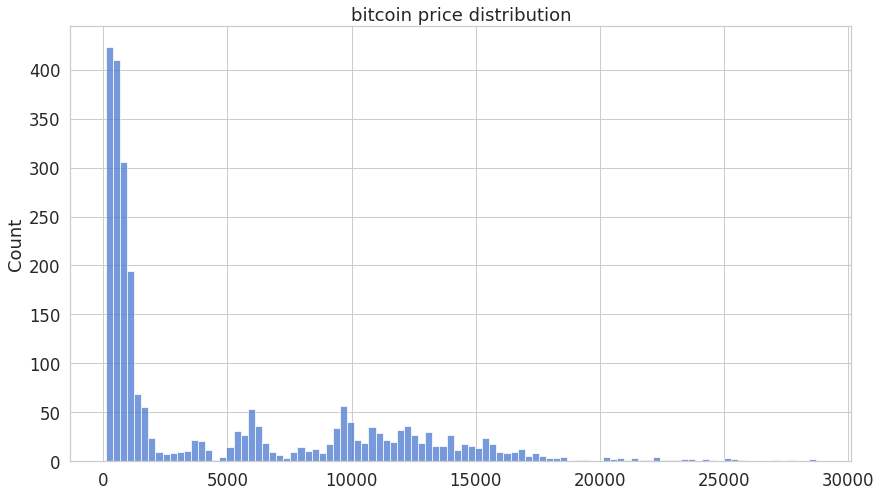

In [ ]:
sns.histplot(price_mean, bins=100).set_title('bitcoin price distribution')

In [ ]:
price_mean_bins = np.linspace(min(price_mean), max(price_mean), 100)
price_mean_bins = np.append(price_mean_bins, np.inf)

In [ ]:
price_diff_bins = np.linspace(-800, 800, 110)
price_diff_bins = np.append(price_diff_bins, np.inf)
price_diff_bins = np.insert(price_diff_bins, 55, 0)

In [ ]:
def get_state(price, fluc):
  for i in range(len(price_mean_bins)):
    if price < price_mean_bins[i]:
      break
  for j in range(len(price_diff_bins)):
    if fluc < price_diff_bins[j]:
      break
  return (i, j)

In [ ]:
class Environment():
  def __init__(self, price_mean):
    self.price_mean = price_mean
    self.day = 0
    self.nA = 9

  def get_day(self):
    return self.day

  def get_date_price(self, day):
    if day <= 0:
      return self.price_mean[0]
    return self.price_mean[day]

  def get_reward(self, bitcoin):
    reward = 0
    # if (bitcoin <= 0.01 and self.day > 1000) or (bitcoin < 0.1 and self.day > 1000):
    #   reward -= 10
    reward += bitcoin * (self.get_date_price(self.day) - self.get_date_price(self.day - 1))
    return reward

  def step(self, bitcoin):
    self.day += 1
    return self.get_reward(bitcoin)

  def reset(self):
    self.day = 0

In [ ]:
env = Environment(price_mean)

In [ ]:
def find_tomorrow_price(prices):
  prices = prices[-99:]
  prices = np.expand_dims(prices, (1))
  prices = scaler.transform(prices)
  pricesT = np.zeros(shape = (1, 99, 1))
  pricesT[0] = prices
  tomorrow_price = open_model.predict(pricesT)
  tomorrow_price = scaler.inverse_transform(tomorrow_price)[0, 0]
  return tomorrow_price

In [ ]:
def e_greedy(s, q):
    p = [epsilon / env.nA for a in range(env.nA)]
    p[np.argmax(q[s])] += 1 - epsilon
    action = np.random.choice(range(env.nA), p=p)
    return action, p
def get_fluc(today, prices, trainable):
  flucs = []
  if trainable:
    for i in range(-2, 0):
      flucs.append(env.get_date_price(today + i + 1) - env.get_date_price(today + i))
  else:
    tomorrow_price = find_tomorrow_price(prices)
    for i in range(-1, 0):
      flucs.append(env.get_date_price(today + i + 1) - env.get_date_price(today + i))
    flucs.append(tomorrow_price - env.get_date_price(today))
  return np.mean(flucs)

In [ ]:
discount_factor = 1
starting_alpha = .01
alpha = starting_alpha
starting_epsilon = .01
epsilon = starting_epsilon
q1 = np.zeros(shape=(len(price_mean_bins), len(price_diff_bins), 9))
q2 = np.zeros(shape=(len(price_mean_bins), len(price_diff_bins), 9))
double_qlearning_rewards = []
num_episodes = 400
for i in range(num_episodes):
    prices = []
    episode_rewards = 0
    env.reset()
    fluc = get_fluc(env.get_day(), None, True)
    s = get_state(env.get_date_price(env.get_day()), fluc)
    while True:
        prices.append(env.get_date_price(env.get_day()))
        totalQ = q1 + q2
        a, probs = e_greedy(s, totalQ)
        r = env.step(a)
        if len(prices) >= 99:
          fluc = get_fluc(env.get_day(), prices, False)
        else:
          fluc = get_fluc(env.get_day(), None, True)
        next_s = get_state(env.get_date_price(env.get_day()), fluc)

        episode_rewards += r
        if np.random.rand() < .5:
            q1[s][a] += alpha*(r + discount_factor*q2[next_s][np.argmax(q1[next_s])] - q1[s][a])
        else:
            q2[s][a] += alpha*(r + discount_factor*q1[next_s][np.argmax(q2[next_s])] - q2[s][a])
        s = next_s
        if env.get_day() == 2500:
            double_qlearning_rewards.append(episode_rewards)
            break
    if (i + 1)%5 == 0:
        epsilon -= starting_epsilon / 90
        alpha -= starting_alpha / 90
        print("\rEpisode {}/{}.".format(i + 1, num_episodes), end="")
        sys.stdout.flush()

Episode 400/400.

Text(1020, 197413.61253722507, '197414.0')

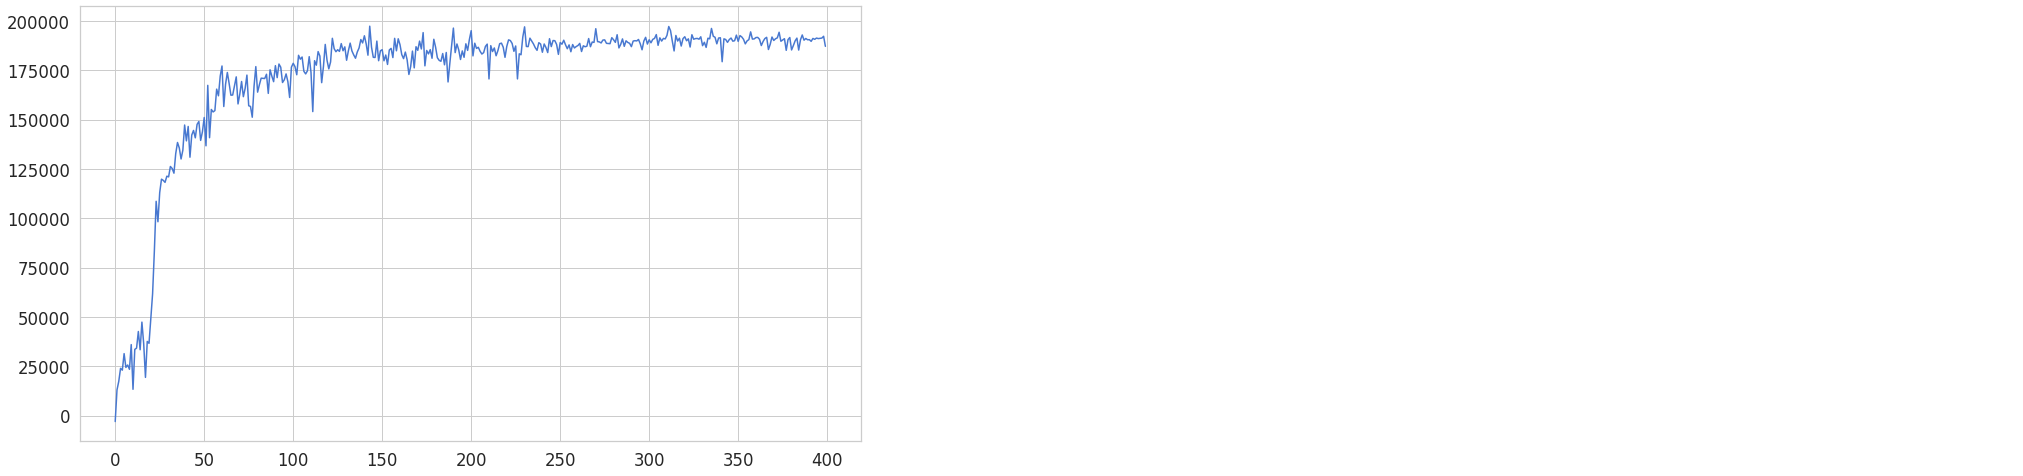

In [ ]:
sns.lineplot(data=double_qlearning_rewards)
plt.annotate(str(np.round(max(double_qlearning_rewards))), (1020, max(double_qlearning_rewards)))

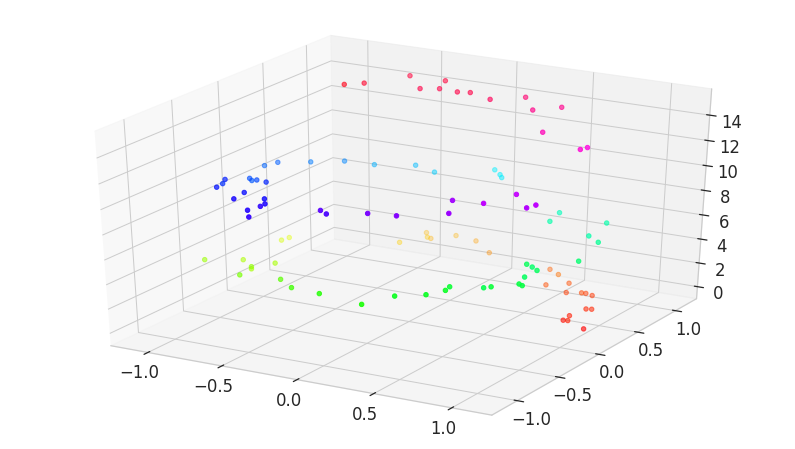

In [ ]:
fig = plt.figure()
ax = plt.axes(projection="3d")

z_points = 15 * np.random.random(100)
x_points = np.cos(z_points) + 0.1 * np.random.randn(100)
y_points = np.sin(z_points) + 0.1 * np.random.randn(100)
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

plt.show()

In [ ]:
totalQ.shape

(101, 112, 9)

In [ ]:
x,y,z = totalQ.nonzero()

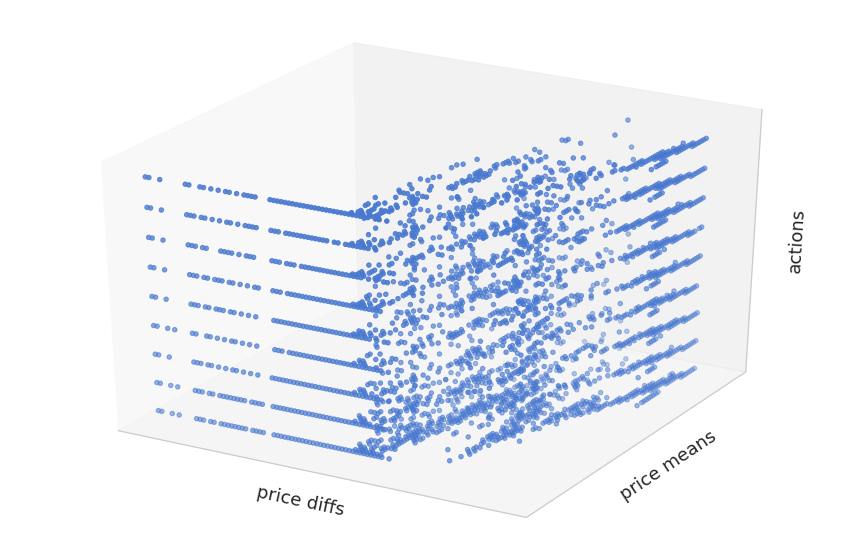

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-x, y, z, zdir='z', cmap='Blues')
ax.set_ylabel('price means')
ax.set_xlabel('price diffs')
ax.set_zlabel('actions')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()